In [1]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import DBSCAN
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn import preprocessing 
from sklearn import tree 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

In [2]:
df_train = pd.read_csv("playground-series-s4e1/train.csv")
df_test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [3]:
df = pd.concat([df_test,df_train])
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,NaN
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,NaN
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,NaN
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,NaN
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275057 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               275057 non-null  int64  
 1   CustomerId       275057 non-null  int64  
 2   Surname          275057 non-null  object 
 3   CreditScore      275057 non-null  int64  
 4   Geography        275057 non-null  object 
 5   Gender           275057 non-null  object 
 6   Age              275057 non-null  float64
 7   Tenure           275057 non-null  int64  
 8   Balance          275057 non-null  float64
 9   NumOfProducts    275057 non-null  int64  
 10  HasCrCard        275057 non-null  float64
 11  IsActiveMember   275057 non-null  float64
 12  EstimatedSalary  275057 non-null  float64
 13  Exited           165034 non-null  float64
dtypes: float64(6), int64(5), object(3)
memory usage: 31.5+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
#encoding Gender
label_encoder = preprocessing.LabelEncoder() 
df['Gender']= label_encoder.fit_transform(df['Gender']) 

#encoding Geography
label_encoder = preprocessing.LabelEncoder() 
df['Geography']= label_encoder.fit_transform(df['Geography']) 

In [7]:
#Drop Unwanted Columns
df = df.drop(columns=['id', 'Surname','CustomerId'])
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,NaN
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,NaN
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,NaN
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,NaN
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0.0
165030,792,0,1,35.0,3,0.00,1,0.0,0.0,131834.45,0.0
165031,565,0,1,31.0,5,0.00,1,1.0,1.0,127429.56,0.0
165032,554,2,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0.0


<Axes: >

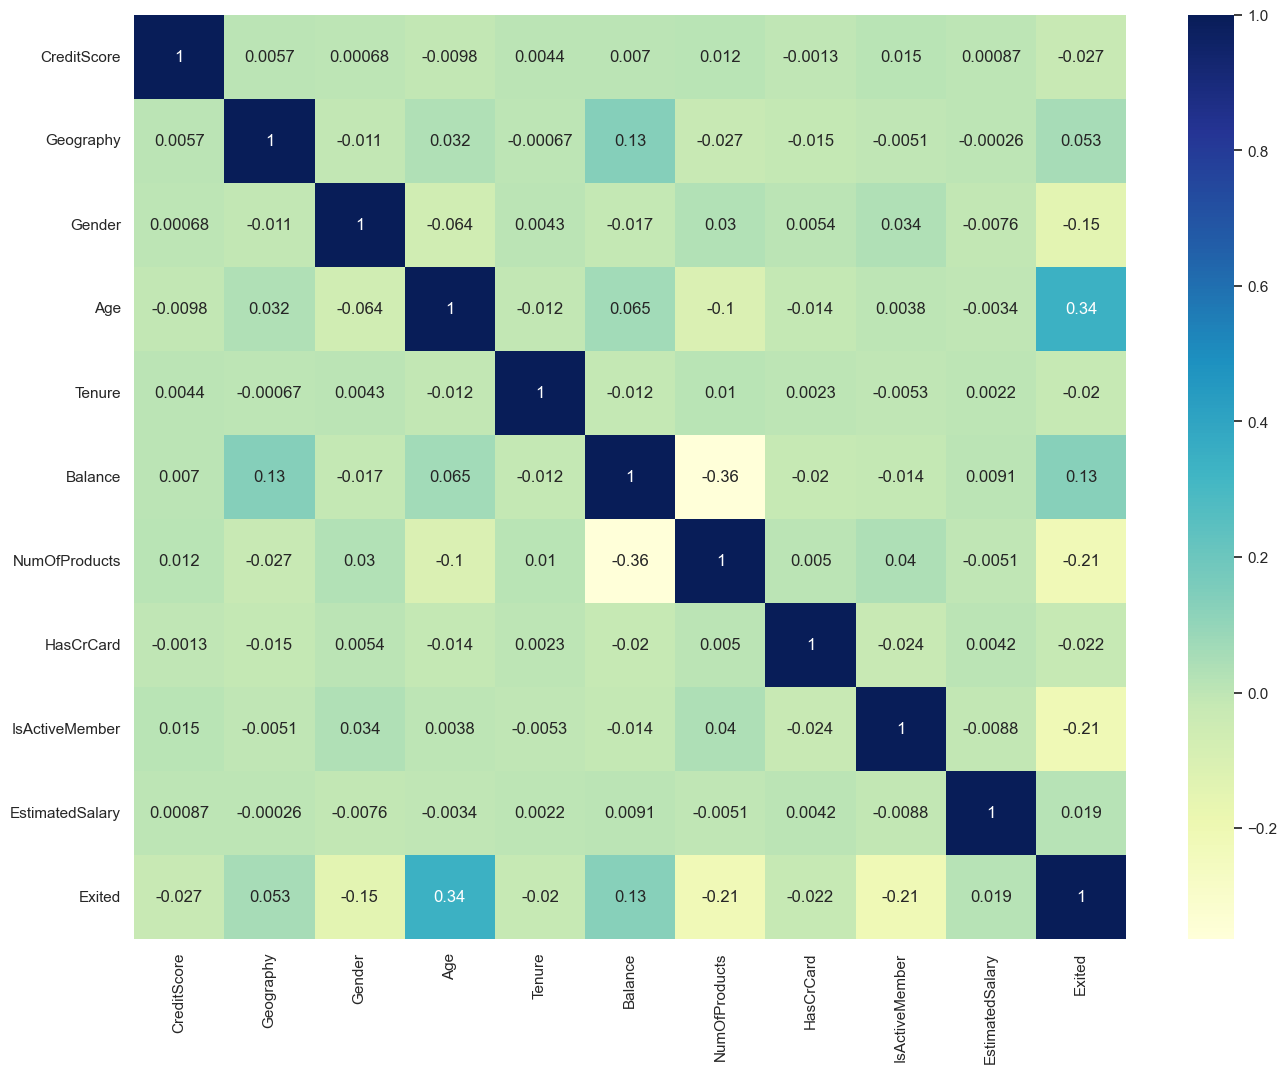

In [8]:
#Understanding the General Data
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True) 
  

# Observations:
## High Corr:
    1. Age , Exited
    2. Gender, Exited
    3. Num of Products, Exited
    4. Active Member, Exited

In [9]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,NaN
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,NaN
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,NaN
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,NaN
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0.0
165030,792,0,1,35.0,3,0.00,1,0.0,0.0,131834.45,0.0
165031,565,0,1,31.0,5,0.00,1,1.0,1.0,127429.56,0.0
165032,554,2,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0.0


In [10]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the DataFrame (learns the mean and standard deviation)
scaler.fit(df)

# Transform the DataFrame using the learned scaling parameters
df_scaled = scaler.transform(df)

# If you want the result as a DataFrame:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.878997,-0.792217,-1.137018,-1.706099,-1.072946,-0.882407,0.816582,-1.748789,1.006511,0.964589,NaN
1,0.330661,-0.792217,-1.137018,0.888400,-1.072946,-0.882407,-1.014326,0.571824,-0.993531,-0.793884,NaN
2,-0.006048,-0.792217,-1.137018,-0.465252,0.708843,-0.882407,0.816582,0.571824,-0.993531,0.525213,NaN
3,0.305720,-0.792217,0.879493,-0.239643,1.065201,-0.882407,-1.014326,0.571824,-0.993531,0.029046,NaN
4,1.191140,0.433365,0.879493,-0.014035,1.777917,1.048363,-1.014326,0.571824,-0.993531,0.536129,NaN
...,...,...,...,...,...,...,...,...,...,...,...
275052,0.131130,1.658947,-1.137018,-0.578056,-1.072946,-0.882407,-1.014326,0.571824,1.006511,0.385069,-0.518063
275053,1.689968,-0.792217,0.879493,-0.352447,-0.716588,-0.882407,-1.014326,-1.748789,-0.993531,0.385063,-0.518063
275054,-1.140881,-0.792217,0.879493,-0.803665,-0.003872,-0.882407,-1.014326,0.571824,1.006511,0.297468,-0.518063
275055,-1.278059,1.658947,-1.137018,-0.916469,0.708843,1.689536,-1.014326,-1.748789,1.006511,-0.821252,-0.518063


# Preparing data for Training

In [11]:
df_train_model = df[df['Exited'].notnull()]
df_test_model = df[df['Exited'].isnull()]
df_test_model = df_test_model.drop("Exited", axis=1)

In [12]:

X = df_train_model.drop("Exited", axis=1)
y = df_train_model["Exited"]
X_test = df_test_model

# Preparing The Models:

## Spliting Dataset to train, validate and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Initialize Table of Model Performances

In [14]:
model_metrics = pd.DataFrame(columns=['model','accuracy_score','precision_score','recall_score','f1_score','roc_auc_score'])

## Tree

### Descision Tree

In [15]:
if False:
        DTC_tree = DecisionTreeClassifier()
        params={
                'criterion':['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'max_depth': [None,5,10,50,100,150, 200],
                'min_samples_split': [2],
                'min_samples_leaf': [1],
                'min_weight_fraction_leaf':[0],
                'max_features': ['sqrt', 'log2'],
                'random_state': [42],
                }
        gs=GridSearchCV(estimator=DTC_tree, param_grid=params, cv=None) 
        gs = gs.fit(X, y)
        best_params=gs.best_params_ 
        accuracy=gs.best_score_ 
        print('best_params:','\n',best_params)
        print('accuracy:','\n',accuracy)


In [16]:
DTC_tree = DecisionTreeClassifier()

DTC_tree.fit(X_train,y_train)
predicted_value = DTC_tree.predict(X_test)
#tree.plot_tree(DTC_tree)
roc = roc_auc_score(y_train, DTC_tree.predict_proba(X_train)[:, 1])
model_metrics.loc[len(model_metrics.index)] = ['Descision Tree', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc]  



### Extra Tree Classifier

In [17]:
if False:
        ETC_tree = ExtraTreeClassifier()
        params={
                'criterion':['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'max_depth': [None,5,10,50,100,150, 200],
                'min_samples_split': [2],
                'min_samples_leaf': [1],
                'min_weight_fraction_leaf':[0],
                'max_features': ['sqrt', 'log2'],
                'random_state': [42],
                }
        gs=GridSearchCV(estimator=ETC_tree, param_grid=params, cv=None) 
        gs = gs.fit(X, y)
        best_params=gs.best_params_ 
        accuracy=gs.best_score_ 
        print('best_params:','\n',best_params)
        print('accuracy:','\n',accuracy)


In [18]:
ETC_tree = ExtraTreeClassifier()
ETC_tree.fit(X_train,y_train)
predicted_value = ETC_tree.predict(X_test)
roc = roc_auc_score(y_train, ETC_tree.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Extra Tree Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


## Neighbours

### KNeighborsClassifier

In [19]:
if False:        
        KNC = KNeighborsClassifier()
        params={
                'n_neighbors': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91,101],
                'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                }
        gs=GridSearchCV(estimator=KNC, param_grid=params, cv=None) 
        gs = gs.fit(X, y)
        best_params=gs.best_params_ 
        accuracy=gs.best_score_ 
        print('best_params:','\n',best_params)
        print('accuracy:','\n',accuracy)


In [20]:
KNC = KNeighborsClassifier()
KNC.fit(X_train,y_train)
predicted_value = KNC.predict(X_test)
roc = roc_auc_score(y_train, KNC.predict_proba(X_train)[:, 1])
model_metrics.loc[len(model_metrics.index)] = ['K Neighbours Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


## Naive Bayes

### BernoulliNB

In [21]:
BNB = BernoulliNB()
BNB.fit(X_train,y_train)
predicted_value = BNB.predict(X_test)
roc = roc_auc_score(y_train, BNB.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Naive Bayes', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


## Bagging Classifier

In [22]:
if False:
    acc_all = []
    for n in range(50,500,50):
        BClassifier = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n)
        BClassifier.fit(X_train,y_train)
        predicted_value = BClassifier.predict(X_test)
        acc_all.append(accuracy_score(y_test, predicted_value))
        print(n,'\t:\t',acc_all[-1])
    print("Best Performing N Estimator")
    print("N\t:\tAcc")
    print(list(range(50,500,50))[acc_all.index(max(acc_all))],'\t:\t',max(acc_all))

In [23]:
dts = DecisionTreeClassifier(**{
    'criterion': 'entropy',
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0,
    'random_state': 42,
    'splitter': 'best'
    })
BClassifier = BaggingClassifier(estimator=dts, n_estimators=450)
BClassifier.fit(X_train,y_train)
predicted_value = BClassifier.predict(X_test)
roc = roc_auc_score(y_train, BClassifier.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Bagging Descision Tree Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


In [24]:
ETC_tree = ExtraTreeClassifier(**{
    'criterion': 'entropy',
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0,
    'random_state': 42,
    'splitter': 'best'
 })
BClassifier = BaggingClassifier(estimator=ETC_tree, n_estimators=450)
BClassifier.fit(X_train,y_train)
predicted_value = BClassifier.predict(X_test)
roc = roc_auc_score(y_train, BClassifier.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Bagging Extra Tree Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


## Boosting

### Gradient Bosting

In [25]:
if False:        
        GBoosting = GradientBoostingClassifier()
        params={
                'n_estimators': [100, 200, 300, 400, 500, 600],
                'learning_rate': [0.05, 0.1], 
                'max_depth': [1, 2, 3, 4, 5], 
                'random_state' : [42]
                }
        gs=GridSearchCV(estimator=GBoosting, param_grid=params, cv=None) 
        gs = gs.fit(X, y)
        best_params=gs.best_params_ 
        accuracy=gs.best_score_ 
        print( 'best_params:','\n',best_params)
        print('accuracy:','\n',accuracy)


In [26]:
GBoosting = GradientBoostingClassifier()
GBoosting.fit(X_train,y_train)
predicted_value = GBoosting.predict(X_test)
roc = roc_auc_score(y_train, GBoosting.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Gradient Boosting', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


### AdaBoostClassifier

In [27]:
if False:        
        Ada = AdaBoostClassifier()
        params={
                'n_estimators': [100, 200, 300, 400, 500, 600],
                'learning_rate': [0.05, 0.1],
                'random_state' : [42]
                }
        gs=GridSearchCV(estimator=Ada, param_grid=params, cv=None) 
        gs = gs.fit(X, y)
        best_params=gs.best_params_ 
        accuracy=gs.best_score_ 
        print( 'best_params:','\n',best_params)
        print('accuracy:','\n',accuracy)


In [28]:
Ada = AdaBoostClassifier()
Ada.fit(X_train,y_train)
predicted_value = Ada.predict(X_test)
roc = roc_auc_score(y_train, Ada.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Ada Boosting', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


### XGBClassifier

In [29]:
if False:        
        xgb = XGBClassifier()
        params={
                'booster':['gbtree'],
                'lambda' : [0, 0.5, 1],
                'alpha' : [0, 0.5, 1],
                'random_state' : [42]
                }
        gs=GridSearchCV(estimator=xgb, param_grid=params, cv=None) 
        gs = gs.fit(X, y)
        best_params=gs.best_params_ 
        accuracy=gs.best_score_ 
        print( 'best_params:','\n',best_params)
        print('accuracy:','\n',accuracy)


In [30]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
predicted_value = xgb.predict(X_test)
roc = roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['XGBoost Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


## LGBM Classifier

In [31]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
predicted_value = lgbm.predict(X_test)
roc = roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1])
model_metrics.loc[len(model_metrics.index)] = ['LGBM Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


[LightGBM] [Info] Number of positive: 23464, number of negative: 87108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 110572, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212206 -> initscore=-1.311681
[LightGBM] [Info] Start training from score -1.311681


## CatBoost Classifier

In [32]:
cat  = CatBoostClassifier()
cat.fit(X_train,y_train)
predicted_value = cat.predict(X_test)
roc = roc_auc_score(y_train, cat.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['CatBoost Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 


Learning rate set to 0.076837
0:	learn: 0.6222602	total: 135ms	remaining: 2m 14s
1:	learn: 0.5664674	total: 155ms	remaining: 1m 17s
2:	learn: 0.5245596	total: 174ms	remaining: 57.8s
3:	learn: 0.4899777	total: 194ms	remaining: 48.4s
4:	learn: 0.4609441	total: 215ms	remaining: 42.9s
5:	learn: 0.4380620	total: 236ms	remaining: 39.2s
6:	learn: 0.4204733	total: 256ms	remaining: 36.3s
7:	learn: 0.4061401	total: 273ms	remaining: 33.9s
8:	learn: 0.3946032	total: 293ms	remaining: 32.3s
9:	learn: 0.3847446	total: 315ms	remaining: 31.1s
10:	learn: 0.3766063	total: 334ms	remaining: 30s
11:	learn: 0.3700389	total: 352ms	remaining: 29s
12:	learn: 0.3639185	total: 371ms	remaining: 28.2s
13:	learn: 0.3587252	total: 391ms	remaining: 27.6s
14:	learn: 0.3546276	total: 410ms	remaining: 26.9s
15:	learn: 0.3509161	total: 428ms	remaining: 26.3s
16:	learn: 0.3479350	total: 447ms	remaining: 25.9s
17:	learn: 0.3449003	total: 468ms	remaining: 25.6s
18:	learn: 0.3425637	total: 486ms	remaining: 25.1s
19:	learn: 0.

# Observations

In [33]:
model_metrics.sort_values(by=['accuracy_score'],ascending=False)

,model,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
9,LGBM Classifier,0.866384,0.743420,0.557127,0.636931,0.898825
10,CatBoost Classifier,0.865741,0.744543,0.550755,0.633153,0.910959
6,Gradient Boosting,0.863905,0.749537,0.530244,0.621102,0.889244
8,XGBoost Classifier,0.863556,0.728076,0.560880,0.633634,0.918255
4,Bagging Descision Tree Classifier,0.863501,0.759649,0.513660,0.612893,0.905572
5,Bagging Extra Tree Classifier,0.863336,0.760717,0.511129,0.611433,0.905573
7,Ada Boosting,0.860233,0.735456,0.524134,0.612068,0.880594
0,Descision Tree,0.796776,0.516242,0.539583,0.527654,1.000000
1,Extra Tree Classifier,0.794995,0.512571,0.519595,0.516059,1.000000
3,Naive Bayes,0.792901,0.523360,0.174042,0.261217,0.703179


In [34]:
model_metrics.sort_values(by=['roc_auc_score'],ascending=False)

,model,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,Descision Tree,0.796776,0.516242,0.539583,0.527654,1.000000
1,Extra Tree Classifier,0.794995,0.512571,0.519595,0.516059,1.000000
8,XGBoost Classifier,0.863556,0.728076,0.560880,0.633634,0.918255
10,CatBoost Classifier,0.865741,0.744543,0.550755,0.633153,0.910959
5,Bagging Extra Tree Classifier,0.863336,0.760717,0.511129,0.611433,0.905573
4,Bagging Descision Tree Classifier,0.863501,0.759649,0.513660,0.612893,0.905572
9,LGBM Classifier,0.866384,0.743420,0.557127,0.636931,0.898825
6,Gradient Boosting,0.863905,0.749537,0.530244,0.621102,0.889244
7,Ada Boosting,0.860233,0.735456,0.524134,0.612068,0.880594
2,K Neighbours Classifier,0.756785,0.292122,0.109715,0.159518,0.824152


# Implimenting Ensemble Methods

## Stacking Classifier

In [35]:
base_models = [
    ('catboost', CatBoostClassifier()),
    ('lgbm',LGBMClassifier())
    
]
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
predicted_value = stacking_clf.predict(X_test)
roc = roc_auc_score(y_train, stacking_clf.predict_proba(X_train)[:, 1])

model_metrics.loc[len(model_metrics.index)] = ['Stacking Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 

Learning rate set to 0.076837
0:	learn: 0.6222602	total: 23.4ms	remaining: 23.3s
1:	learn: 0.5664674	total: 43.7ms	remaining: 21.8s
2:	learn: 0.5245596	total: 63.1ms	remaining: 21s
3:	learn: 0.4899777	total: 87.3ms	remaining: 21.7s
4:	learn: 0.4609441	total: 110ms	remaining: 21.9s
5:	learn: 0.4380620	total: 132ms	remaining: 21.8s
6:	learn: 0.4204733	total: 151ms	remaining: 21.5s
7:	learn: 0.4061401	total: 171ms	remaining: 21.1s
8:	learn: 0.3946032	total: 193ms	remaining: 21.2s
9:	learn: 0.3847446	total: 220ms	remaining: 21.8s
10:	learn: 0.3766063	total: 249ms	remaining: 22.4s
11:	learn: 0.3700389	total: 273ms	remaining: 22.4s
12:	learn: 0.3639185	total: 294ms	remaining: 22.3s
13:	learn: 0.3587252	total: 314ms	remaining: 22.1s
14:	learn: 0.3546276	total: 333ms	remaining: 21.9s
15:	learn: 0.3509161	total: 350ms	remaining: 21.5s
16:	learn: 0.3479350	total: 367ms	remaining: 21.2s
17:	learn: 0.3449003	total: 388ms	remaining: 21.2s
18:	learn: 0.3425637	total: 410ms	remaining: 21.2s
19:	learn

,model,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
11,Stacking Classifier,0.866898,0.749348,0.551890,0.635637,0.904987
9,LGBM Classifier,0.866384,0.743420,0.557127,0.636931,0.898825
10,CatBoost Classifier,0.865741,0.744543,0.550755,0.633153,0.910959
6,Gradient Boosting,0.863905,0.749537,0.530244,0.621102,0.889244
8,XGBoost Classifier,0.863556,0.728076,0.560880,0.633634,0.918255
4,Bagging Descision Tree Classifier,0.863501,0.759649,0.513660,0.612893,0.905572
5,Bagging Extra Tree Classifier,0.863336,0.760717,0.511129,0.611433,0.905573
7,Ada Boosting,0.860233,0.735456,0.524134,0.612068,0.880594
0,Descision Tree,0.796776,0.516242,0.539583,0.527654,1.000000
1,Extra Tree Classifier,0.794995,0.512571,0.519595,0.516059,1.000000


## Voting Classifier

In [36]:

base_models = [
    ('catboost', CatBoostClassifier()),
    ('lgbm',LGBMClassifier())
    
]

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=base_models,
    voting='soft'  # Can be changed to 'soft' if desired
)

# Fit the Voting Classifier
voting_clf.fit(X_train, y_train)
predicted_value = voting_clf.predict(X_test)
roc = roc_auc_score(y_train, voting_clf.predict_proba(X_train)[:, 1])
model_metrics.loc[len(model_metrics.index)] = ['Voting Classifier', accuracy_score(y_test, predicted_value), precision_score(y_test, predicted_value),recall_score(y_test, predicted_value),f1_score(y_test, predicted_value),roc] 

Learning rate set to 0.076837
0:	learn: 0.6222602	total: 26.4ms	remaining: 26.4s
1:	learn: 0.5664674	total: 47.3ms	remaining: 23.6s
2:	learn: 0.5245596	total: 67.8ms	remaining: 22.5s
3:	learn: 0.4899777	total: 87.6ms	remaining: 21.8s
4:	learn: 0.4609441	total: 106ms	remaining: 21.2s
5:	learn: 0.4380620	total: 127ms	remaining: 21s
6:	learn: 0.4204733	total: 146ms	remaining: 20.7s
7:	learn: 0.4061401	total: 165ms	remaining: 20.4s
8:	learn: 0.3946032	total: 184ms	remaining: 20.3s
9:	learn: 0.3847446	total: 206ms	remaining: 20.4s
10:	learn: 0.3766063	total: 225ms	remaining: 20.2s
11:	learn: 0.3700389	total: 246ms	remaining: 20.3s
12:	learn: 0.3639185	total: 268ms	remaining: 20.3s
13:	learn: 0.3587252	total: 289ms	remaining: 20.3s
14:	learn: 0.3546276	total: 308ms	remaining: 20.2s
15:	learn: 0.3509161	total: 324ms	remaining: 20s
16:	learn: 0.3479350	total: 341ms	remaining: 19.7s
17:	learn: 0.3449003	total: 361ms	remaining: 19.7s
18:	learn: 0.3425637	total: 378ms	remaining: 19.5s
19:	learn: 

,model,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
11,Stacking Classifier,0.866898,0.749348,0.551890,0.635637,0.904987
12,Voting Classifier,0.866825,0.747120,0.554683,0.636678,0.906139
9,LGBM Classifier,0.866384,0.743420,0.557127,0.636931,0.898825
10,CatBoost Classifier,0.865741,0.744543,0.550755,0.633153,0.910959
6,Gradient Boosting,0.863905,0.749537,0.530244,0.621102,0.889244
8,XGBoost Classifier,0.863556,0.728076,0.560880,0.633634,0.918255
4,Bagging Descision Tree Classifier,0.863501,0.759649,0.513660,0.612893,0.905572
5,Bagging Extra Tree Classifier,0.863336,0.760717,0.511129,0.611433,0.905573
7,Ada Boosting,0.860233,0.735456,0.524134,0.612068,0.880594
0,Descision Tree,0.796776,0.516242,0.539583,0.527654,1.000000


In [37]:
model_metrics.sort_values(by=['roc_auc_score'],ascending=False)

,model,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,Descision Tree,0.796776,0.516242,0.539583,0.527654,1.000000
1,Extra Tree Classifier,0.794995,0.512571,0.519595,0.516059,1.000000
8,XGBoost Classifier,0.863556,0.728076,0.560880,0.633634,0.918255
10,CatBoost Classifier,0.865741,0.744543,0.550755,0.633153,0.910959
12,Voting Classifier,0.866825,0.747120,0.554683,0.636678,0.906139
5,Bagging Extra Tree Classifier,0.863336,0.760717,0.511129,0.611433,0.905573
4,Bagging Descision Tree Classifier,0.863501,0.759649,0.513660,0.612893,0.905572
11,Stacking Classifier,0.866898,0.749348,0.551890,0.635637,0.904987
9,LGBM Classifier,0.866384,0.743420,0.557127,0.636931,0.898825
6,Gradient Boosting,0.863905,0.749537,0.530244,0.621102,0.889244


# Final Model

In [40]:
base_models = [
    ('catboost', CatBoostClassifier()),
    ('lgbm',LGBMClassifier())
    
]
# Create the Voting Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
# Fit the Voting Classifier
stacking_clf.fit(X, y)

Learning rate set to 0.091167
0:	learn: 0.6112421	total: 28.7ms	remaining: 28.7s
1:	learn: 0.5481782	total: 52.5ms	remaining: 26.2s
2:	learn: 0.5012627	total: 78.9ms	remaining: 26.2s
3:	learn: 0.4659793	total: 105ms	remaining: 26.2s
4:	learn: 0.4389566	total: 130ms	remaining: 25.8s
5:	learn: 0.4172643	total: 152ms	remaining: 25.1s
6:	learn: 0.4012122	total: 176ms	remaining: 24.9s
7:	learn: 0.3884251	total: 199ms	remaining: 24.7s
8:	learn: 0.3773829	total: 227ms	remaining: 25s
9:	learn: 0.3695014	total: 250ms	remaining: 24.7s
10:	learn: 0.3617295	total: 276ms	remaining: 24.9s
11:	learn: 0.3563691	total: 301ms	remaining: 24.8s
12:	learn: 0.3525183	total: 326ms	remaining: 24.8s
13:	learn: 0.3481381	total: 351ms	remaining: 24.7s
14:	learn: 0.3448447	total: 375ms	remaining: 24.6s
15:	learn: 0.3421983	total: 401ms	remaining: 24.7s
16:	learn: 0.3400657	total: 432ms	remaining: 25s
17:	learn: 0.3375973	total: 463ms	remaining: 25.3s
18:	learn: 0.3358993	total: 490ms	remaining: 25.3s
19:	learn: 0

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001ACE4F963B0>),
                               ('lgbm', LGBMClassifier())],
                   final_estimator=LogisticRegression())

In [41]:
final = pd.DataFrame()
temp = pd.read_csv("playground-series-s4e1/test.csv")
final['id'] = temp['id']
predicted_value = voting_clf.predict_proba(df_test_model)[:, 1]
final['Exited'] = predicted_value
final.to_csv('submission.csv', index=False)
final.head()

,id,Exited
0,165034,0.263440
1,165035,0.666373
2,165036,0.010362
3,165037,0.638734
4,165038,0.172200
